In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
full_lumi = luminosity["lep"]["Run2"]
full_lumi = full_lumi/1000
full_lumi

137.64

In [158]:
# get lumi
import pickle as pkl
with open("../combine/templates/v5/hists_templates_Run2.pkl", "rb") as f:
    h = pkl.load(f)

In [159]:
h

{'passHigh': Hist(
   StrCategory(['DYJets', 'Data', 'VBF', 'VH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'Diboson', 'QCD', 'WZQQ', 'ttH'], growth=True, name='Sample'),
   StrCategory(['nominal', 'weight_pileupUp', 'weight_pileupDown', 'weight_isolationUp', 'weight_isolationDown', 'weight_idUp', 'weight_idDown', 'weight_reco_eleUp', 'weight_reco_eleDown', 'weight_L1PrefiringUp', 'weight_L1PrefiringDown', 'weight_trigger_eleUp', 'weight_trigger_eleDown', 'weight_trigger_iso_muUp', 'weight_trigger_iso_muDown', 'weight_trigger_noniso_muUp', 'weight_trigger_noniso_muDown', 'weight_aS_weightUp', 'weight_aS_weightDown', 'weight_UEPS_FSRUp', 'weight_UEPS_FSRDown', 'weight_UEPS_ISRUp', 'weight_UEPS_ISRDown', 'weight_PDF_weightUp', 'weight_PDF_weightDown', 'weight_PDFaS_weightUp', 'weight_PDFaS_weightDown', 'weight_scalevar_3ptUp', 'weight_scalevar_3ptDown', 'weight_scalevar_7ptUp', 'weight_scalevar_7ptDown', 'weight_d1kappa_EWUp', 'weight_d1kappa_EWDown', 'weight_d1K_NLOUp', 'weight_d1K_NLODo

In [173]:
h["passHigh"][{"Sample": "Data", "Systematic": "nominal", "Category": "ggFpt200to300"}].values()

array([ 81., 196., 260., 337., 370., 319., 293., 257., 195.])

In [245]:
import uproot
# f = uproot.open("FitShapesv3withopposite.root")
# f = uproot.open("fitDiagnosticsBlindedvbf.root")
f = uproot.open("fitDiagnosticsBlinded.root")

In [246]:
f.keys()

['shapes_prefit;1',
 'shapes_prefit/passHighBlinded;1',
 'shapes_prefit/passHighBlinded/data;1',
 'shapes_prefit/passHighBlinded/VBF;1',
 'shapes_prefit/passHighBlinded/VH;1',
 'shapes_prefit/passHighBlinded/ggF;1',
 'shapes_prefit/passHighBlinded/qcd;1',
 'shapes_prefit/passHighBlinded/singletop;1',
 'shapes_prefit/passHighBlinded/ttH;1',
 'shapes_prefit/passHighBlinded/ttbar;1',
 'shapes_prefit/passHighBlinded/wjets;1',
 'shapes_prefit/passHighBlinded/zjets;1',
 'shapes_prefit/passHighBlinded/total;1',
 'shapes_prefit/passHighBlinded/total_signal;1',
 'shapes_prefit/passHighBlinded/total_background;1',
 'shapes_prefit/passHighBlinded/total_covar;1',
 'shapes_prefit/total_bin_width;1',
 'shapes_prefit/total_overall;1',
 'shapes_prefit/total_signal;1',
 'shapes_prefit/total_data;1',
 'shapes_prefit/total_background;1',
 'shapes_prefit/overall_total_covar;1',
 'shapes_prefit/overall_total_M1;1',
 'shapes_prefit/overall_total_M2;1',
 'shapes_prefit/overall_total_M3;1',
 'norm_prefit;1',


In [247]:
legend_lab = {
    "shapes_prefit": "Prefit",
    "shapes_fit_b": "Postfit (b)",
    "shapes_fit_s": "Postfit (s+b)"
}
color_by_sample = {
    "total_background": "tab:purple",
    "total_signal": "tab:red",
#     "ggF": "pink",
#     "VH": "tab:brown",
#     "VBF": "tab:gray",
#     "ttH": "tab:olive",
#     "DYJets": "tab:purple",
    "qcd": "tab:orange",
    "Diboson": "orchid",
    "wjets": "tab:green",
    "ttbar": "tab:blue",
    "WZQQ": "salmon",
#     "SingleTop": "tab:cyan",
}

samples = [
    "data",
    "total_background",
    "total_signal",        
#     "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
    "qcd",
]


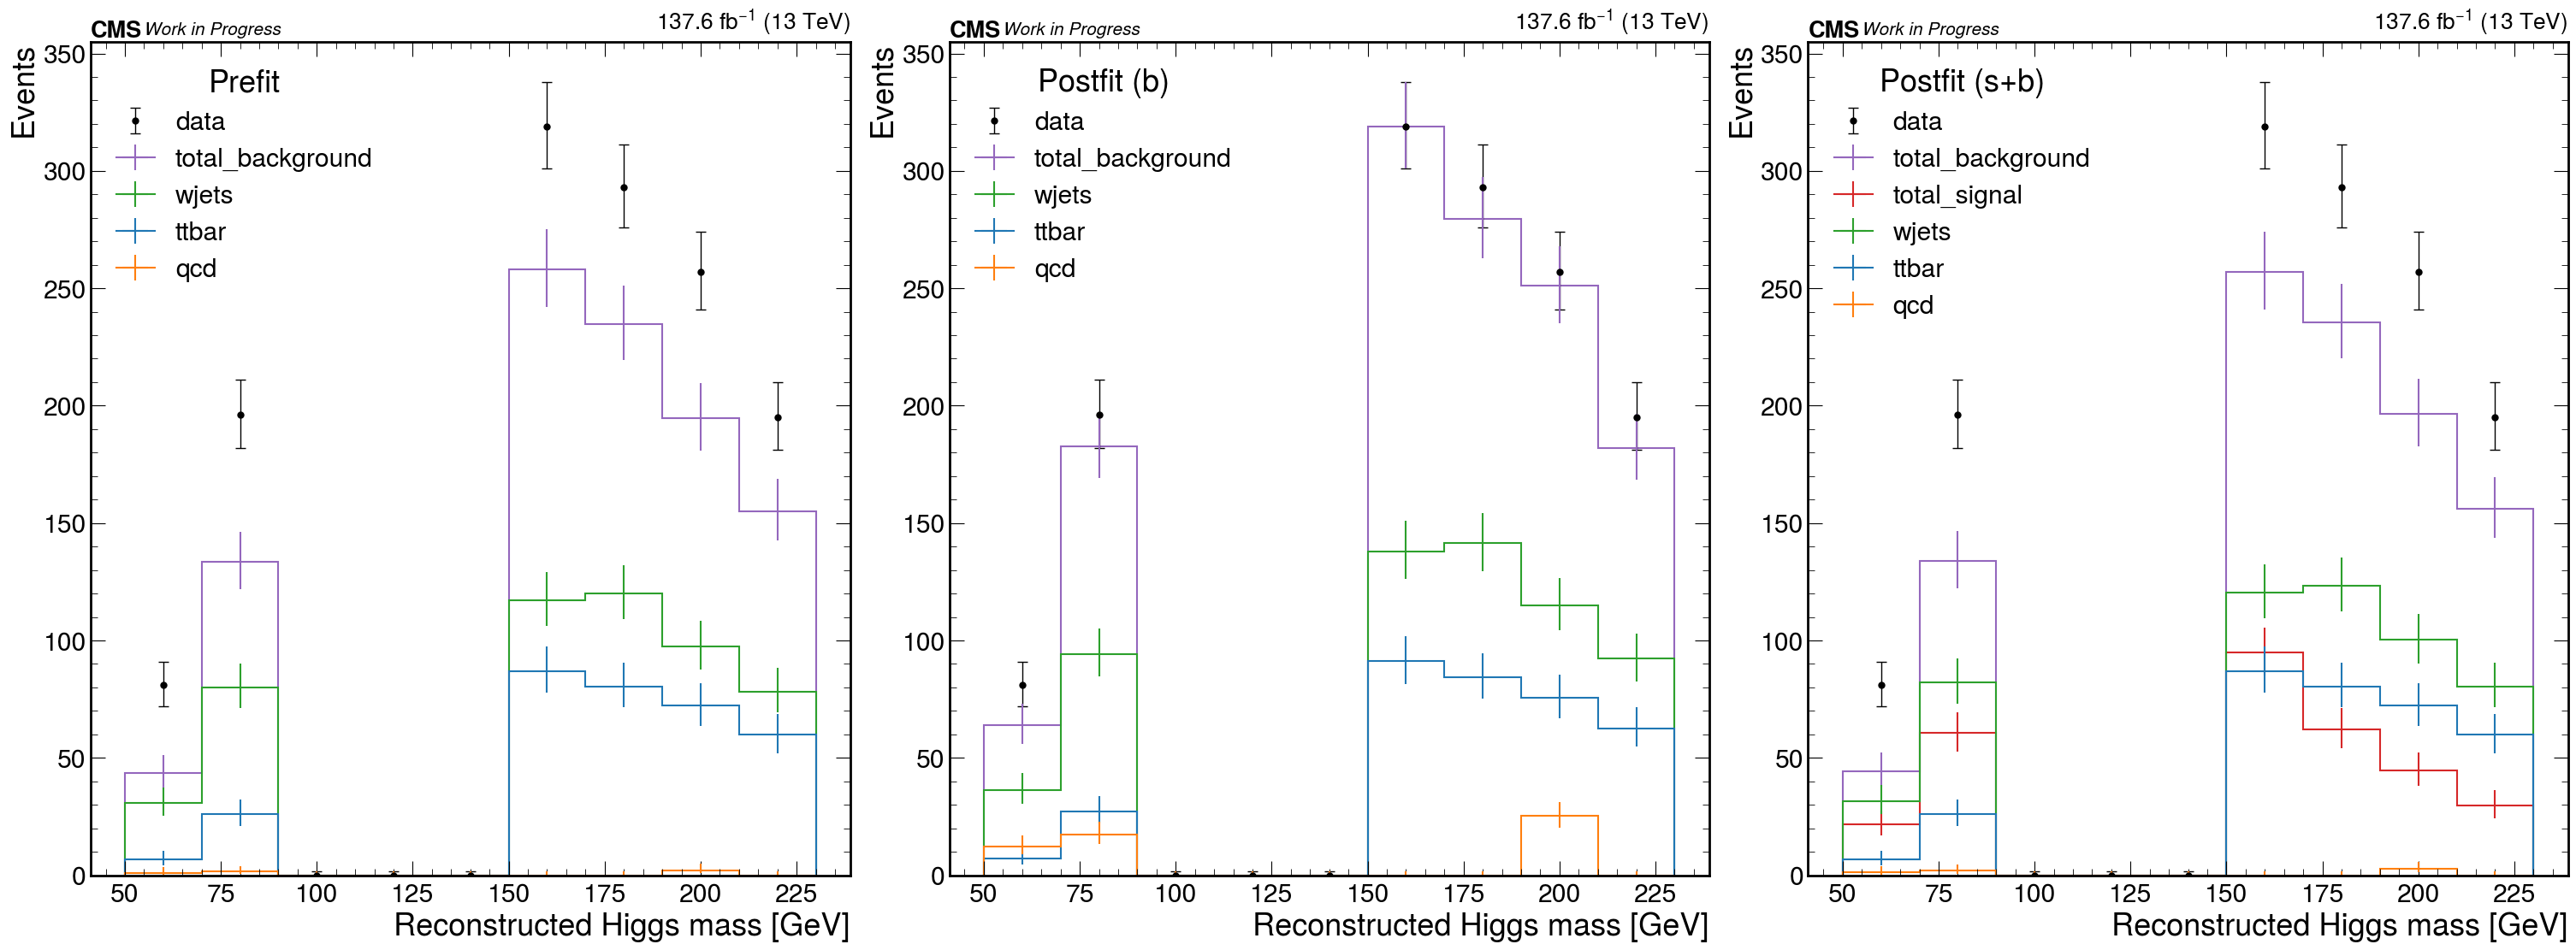

In [265]:
f = uproot.open("fitDiagnosticsBlinded.root")
binwidth = 20

# region = "wjetsCR"
region = "passHighBlinded"
# region = "passMediumBlinded"

fig, axs = plt.subplots(1, 3, figsize=(30,11), constrained_layout=True)
for i, key in enumerate([f"shapes_prefit", f"shapes_fit_b", f"shapes_fit_s"]):

    for sample in samples:
        
        if (sample == "total_signal") and (key!="shapes_fit_s"):
            continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[f"{key}/{region}"]["data"].values()[1]*binwidth,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
#             if "qcd" in sample:
#                 lab = "QCD (data-driven)"
#             else:
#                 lab = sample
            lab = sample

            hep.histplot(             
                f[f"{key}/{region}"][sample].values()*binwidth,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                histtype="step",
                yerr=True,
                label=lab,
                color=color_by_sample[sample]
            )    

    
    axs[i].legend(title=legend_lab[key], loc="upper left")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)   
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/combine.pdf")        

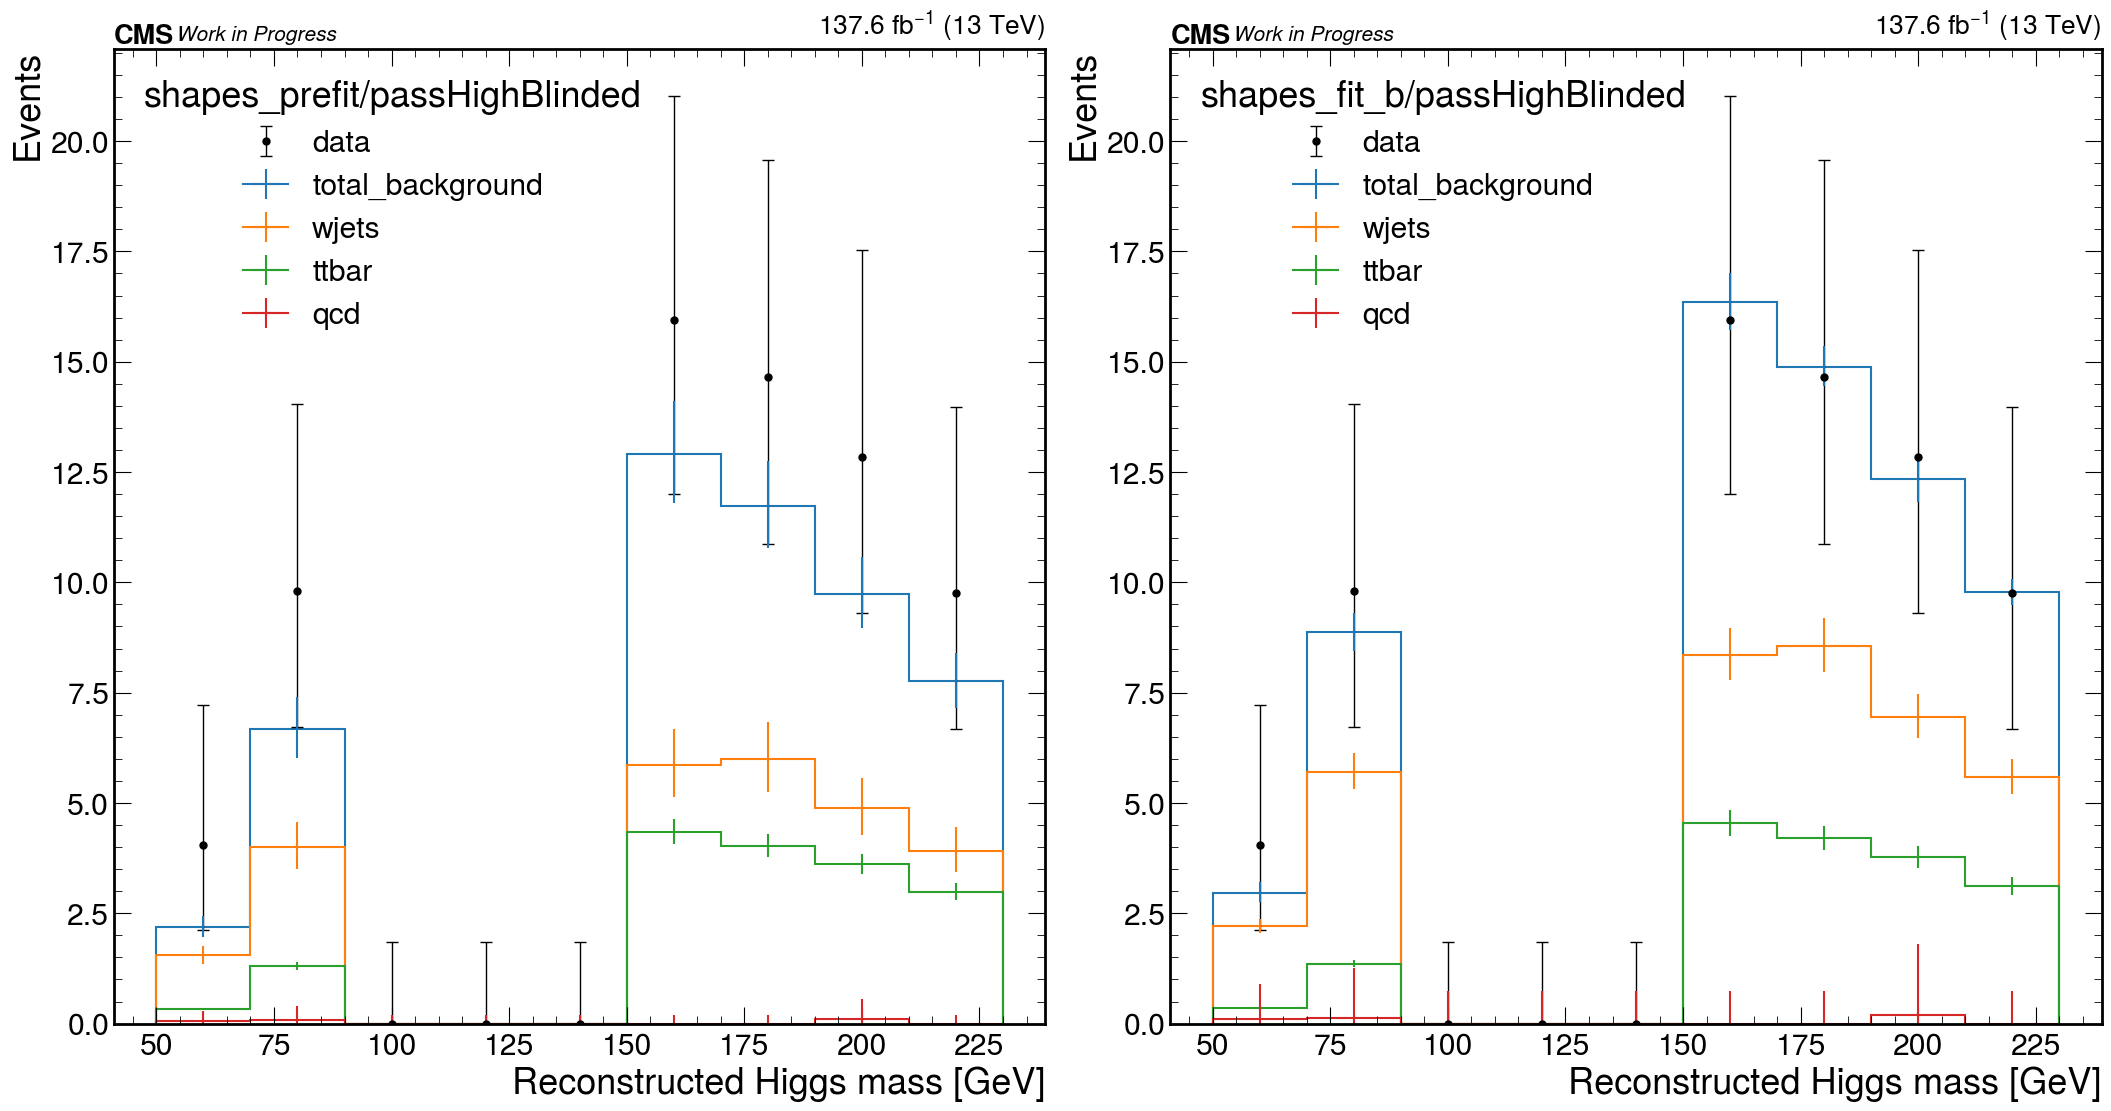

In [130]:
# region = "wjetsCR"
# region = "passMediumBlinded"
region = "passHighBlinded"

fig, axs = plt.subplots(1, 2, figsize=(21,11), constrained_layout=True)
for i, key in enumerate([f"shapes_prefit/{region}", f"shapes_fit_b/{region}"]):

    for sample in samples:
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[key]["data"].values()[1],
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
#             if "qcd" in sample:
#                 lab = "QCD (data-driven)"
#             else:
#                 lab = sample
            lab = sample

            hep.histplot(             
                f[key][sample],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    

    axs[i].legend(title=key, loc="upper left")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)   
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/combine_bfit.pdf")        

In [17]:
samples = [
#     "data",
    "total_background",
    "total_signal",
#     "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
    "zjets",
    "singletop",
    "total_covar"
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

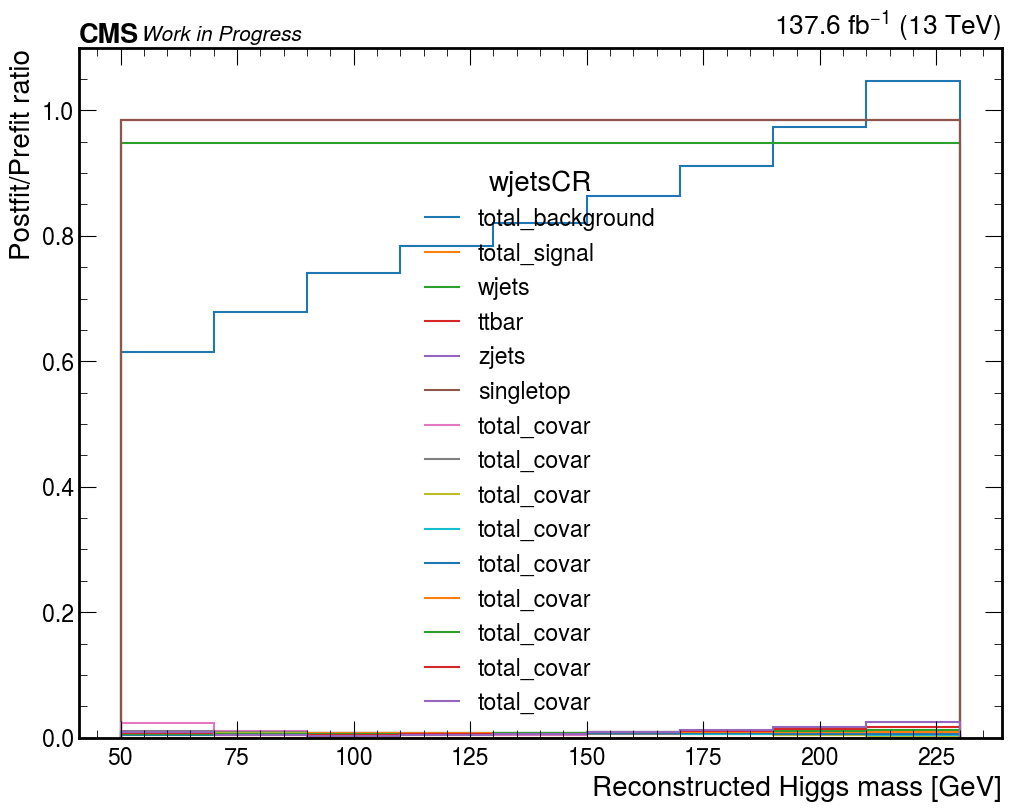

In [10]:
region = "wjetsCR"

if region=="pass":
    region += "Blinded"

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
for sample in samples:


    if sample == "data":
        num = f[f"shapes_fit_b/{region}"]["data"].values()[1]
        den = f[f"shapes_prefit/{region}"]["data"].values()[1]

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            label=sample,
            histtype="errorbar",
            color="k",
            capsize=4,           
        )   

    else:
        num = f[f"shapes_fit_b/{region}"][sample].values()
        den = f[f"shapes_prefit/{region}"][sample].values()

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            histtype="step",
            label=sample,
        )    

ax.legend(title=region)
ax.set_ylabel(f"Postfit/Prefit ratio")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)    
hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [428]:
f["shapes_prefit/passBlinded"]["wjets"].values()

array([1.4160691, 3.8754134, 0.       , 0.       , 0.       , 5.597086 ,
       5.7969   , 4.6152887, 3.6734428], dtype=float32)